# Point Clouds Processing

## Import libraries

In [1]:
import pyvista as pv
import glob
import laspy as lp
import numpy as np
from sklearn.neighbors import KDTree
import matplotlib.pyplot as plt

## Search for path of interest

In [2]:
main_path = '/home/diego/workspace/SQM/SQM_project/Day 1 Pools 120m 50&100kHz/09_EXPORT/*.las'
#main_path = '/home/diego/workspace/SQM/SQM_project/Day 5 Big Pools 100kHz 220m/*'
paths = sorted(glob.glob(main_path))
paths

['/home/diego/workspace/SQM/SQM_project/Day 1 Pools 120m 50&100kHz/09_EXPORT/250111_184803Record001250111_185605_Scanner_1_0.las',
 '/home/diego/workspace/SQM/SQM_project/Day 1 Pools 120m 50&100kHz/09_EXPORT/250111_184803Record001250111_185605_Scanner_1_1.las',
 '/home/diego/workspace/SQM/SQM_project/Day 1 Pools 120m 50&100kHz/09_EXPORT/250111_184803Record002250111_185633_Scanner_1_0.las',
 '/home/diego/workspace/SQM/SQM_project/Day 1 Pools 120m 50&100kHz/09_EXPORT/250111_184803Record002250111_185633_Scanner_1_1.las',
 '/home/diego/workspace/SQM/SQM_project/Day 1 Pools 120m 50&100kHz/09_EXPORT/250111_184803Record003250111_185709_Scanner_1_0.las',
 '/home/diego/workspace/SQM/SQM_project/Day 1 Pools 120m 50&100kHz/09_EXPORT/250111_184803Record003250111_185709_Scanner_1_1.las',
 '/home/diego/workspace/SQM/SQM_project/Day 1 Pools 120m 50&100kHz/09_EXPORT/250111_184803Record004250111_185759_Scanner_1_0.las',
 '/home/diego/workspace/SQM/SQM_project/Day 1 Pools 120m 50&100kHz/09_EXPORT/250111

## Load and subsampling (if necessary) point cloud

In [3]:
def read_point_cloud_in_chunks(file_path, chunk_size):
    """
    Reads a LAS/LAZ file in chunks using laspy.
    
    Parameters:
    - file_path: str, path to the LAS/LAZ file.
    - chunk_size: int, number of points to load per chunk.
    """
    # Open the LAS/LAZ file
    with lp.open(file_path) as las:
        print(f"Total points in the file: {las.header.point_count}")
        
        points = []
        colors = []
        # Read the point cloud in chunks
        for c_las in las.chunk_iterator(chunk_size):
            points.append(np.vstack((c_las.x, c_las.y, c_las.z)).transpose())
            colors.append(np.vstack((c_las.red, c_las.green, c_las.blue)).transpose())
            break
        points = np.vstack(points)
        colors = np.vstack(colors)
            
        print("Number of points after selection: ", len(points))
        # normalize colors
        rgba = colors - colors.min(axis=0)
        # set between 0 and 1
        rgba = rgba / rgba.max(axis=0)
        # set between 0 and 255
        rgba_colors = (rgba * 255).astype(np.uint8)
        return points, colors, rgba_colors


In [4]:
def get_points_and_colors(las_paths: list, limit: int = -1):
    '''
    Get the points and colors from a list of las files. 
    If limit is set to -1, all points are returned.
    Otherwise, limit points are randomly selected.

    Parameters:
    las_paths: list
        List of paths to the las files.
    limit: int
        Number of points to be selected. Default is -1.
    '''
    points = []
    colors = []
    classes = []
    for las_path in las_paths:
        las = lp.read(las_path)
        print(f"Number of points for {las_path}: ", len(las))
        print(f"Classifications: {np.unique(las.classification)}")
        
        points.append(np.vstack((las.x, las.y, las.z)).transpose())
        colors.append(np.vstack((las.red, las.green, las.blue)).transpose())
        classes.append(las.classification)
    
    points = np.vstack(points)
    colors = np.vstack(colors)
    classes = np.vstack(classes)

    if limit > 0:
        idxs = np.random.choice(len(points), limit, replace=False)
        points = points[idxs]
        colors = colors[idxs]
        classes = classes[idxs]
        
    print("Number of points after selection: ", len(points))
    # normalize colors
    rgba = colors - colors.min(axis=0)
    # set between 0 and 1
    rgba = rgba / rgba.max(axis=0)
    # set between 0 and 255
    rgba_colors = (rgba * 255).astype(np.uint8)
    return points, colors, rgba_colors, classes

In [18]:
points, colors, rgba_colors, classes = get_points_and_colors([paths[8]], limit=-1)
#points, colors, rgba_colors = read_point_cloud_in_chunks(paths[0], 500_000)
#points, colors, rgba_colors = get_points_and_colors(paths, limit=1_000_000)

Number of points for /home/diego/workspace/SQM/SQM_project/Day 1 Pools 120m 50&100kHz/09_EXPORT/250111_184803Record005250111_185850_Scanner_1_0.las:  1934796
Classifications: [ 0 65 66]
Number of points after selection:  1934796


In [15]:
# import numpy as np
# import laspy

# name = paths[11].split('/')[-1]
# print(name)

# # Create a header for the LAS file
# header = laspy.LasHeader(point_format=3, version="1.2")  # Point format 3 supports colors

# # Create a LAS file with points and colors
# las = laspy.LasData(header)

# # Add points
# las.x = points[:, 0]
# las.y = points[:, 1]
# las.z = points[:, 2]

# # Add colors (scaled to 16-bit values as per LAS format)
# las.red = (colors[:, 0]).astype(np.uint16)
# las.green = (colors[:, 1]).astype(np.uint16)
# las.blue = (colors[:, 2]).astype(np.uint16)

# # Save to a LAS file
# output_file = "/home/diego/Downloads/new_las/" + name
# las.write(output_file)

# print(f"Saved LAS file to {output_file}")

In [19]:
point_cloud = pv.PolyData(points)
# surf_1 = point_cloud.delaunay_2d() # 2D Delaunay triangulation
# surf_1.is_all_triangles # It should return False if delaunay_2d() was not applied.

In [17]:
#plotter = pv.Plotter()
#plotter.add_mesh(point_cloud, show_edges=False, scalars=rgba_colors, rgb=True)
#plotter.show()

## Trying to filter false positive points (muy a mano aún)

### By quartiles

In [20]:
def plot_hist_with_q(points, q1, q2, q3, title):
    '''
    Plot a histogram of the z values of the points with two vertical lines at the quantiles q1 and q2.

    Parameters:
    points: np.array
        Array of points.
    q1: float
        First quantile.
    q2: float
        Second quantile.
    title: str
        Title of the plot.
    '''
    plt.hist(points, bins=500)
    plt.axvline(x=q1, color='r', linestyle='dashed', linewidth=2)
    plt.axvline(x=q2, color='r', linestyle='dashed', linewidth=2)
    plt.axvline(x=q3, color='r', linestyle='dashed', linewidth=2)
    plt.title(title)
    plt.show()

In [21]:
local_maxima = point_cloud.points

In [20]:
# import numpy as np
# import pyvista as pv
# from sklearn.decomposition import PCA

# # Step 1: Translate the point cloud to align its centroid with the origin
# centroid = np.mean(local_maxima, axis=0)
# points_centered = local_maxima - centroid

# # Step 2: Use PCA to find the principal axes of the point cloud
# pca = PCA(n_components=3)
# pca.fit(points_centered)

# # Get the rotation matrix to align the point cloud with the PyVista axes
# rotation_matrix = pca.components_.T

# # Rotate the point cloud
# points_aligned = points_centered @ rotation_matrix

# # Step 3: Visualize in PyVista
# point_cloud = pv.PolyData(points_aligned)
# point_cloud["Point ID"] = np.arange(len(points))  # Add an ID for visualization

In [21]:
# from sklearn.decomposition import PCA
# # Step 1: Compute the centroid of the point cloud
# centroid = points.mean(axis=0)

# # Step 2: Center the point cloud at the origin
# centered_points = points - centroid

# # Step 3: Perform PCA to determine principal axes
# pca = PCA(n_components=3)
# pca.fit(centered_points)

# # Principal components (directions of maximum variance)
# principal_axes = pca.components_

# # Step 4: Construct a rotation matrix to align the principal axes to PyVista axes
# # PyVista's default coordinate axes are aligned with the identity matrix
# rotation_matrix = principal_axes.T  # Transform from point cloud basis to standard basis

# # Step 5: Apply the rotation to the point cloud
# aligned_points = centered_points @ rotation_matrix

# # Create the aligned point cloud
# aligned_point_cloud = pv.PolyData(aligned_points)

# # Step 6: Translate the aligned point cloud back to the original scale and position
# final_points = aligned_points + centroid
# point_cloud = pv.PolyData(final_points)

In [34]:
# Add the RGBA colors to the point cloud as a scalar array
point_cloud["colors"] = rgba_colors

# Create the PyVista plotter
plotter = pv.Plotter()

# Add aligned coordinate axes
plotter.add_axes()

# Add the point cloud with colors
plotter.add_mesh(point_cloud, scalars="colors", rgb=True, pickable=True)

# List to store picked points
picked_points = []

# Callback function to handle point picking
def callback(point):
    # Add the picked point to the list
    picked_points.append(point)

    # If two points are picked, create a perpendicular plane
    if len(picked_points) == 2:
        # Extract the two points
        p1, p2 = picked_points

        # Compute the normal vector of the plane (vector between the points)
        normal = np.array(p2) - np.array(p1)
        # Rotate the normal vector by 90 degrees to get a perpendicular vector
        normal = np.array([normal[1], -normal[0], normal[2]])
        normal = normal / np.linalg.norm(normal)  # Normalize the vector

        # Compute the midpoint between the two points (center of the plane)
        midpoint = (np.array(p1) + np.array(p2)) / 2

        # Define the plane using PyVista's pv.Plane
        plane = pv.Plane(center=midpoint, direction=normal, i_size=100, j_size=1000)

        # Add the plane to the plotter
        plotter.add_mesh(plane, color="red", opacity=0.5, name="picked_plane")

        # Update the render window to display the new plane
        plotter.render()

        # Reset picked points for the next selection
        #picked_points.clear()

# Enable point picking and assign the callback
plotter.enable_point_picking(callback=callback, show_message=True)

# Show the plotter
plotter.show()

Widget(value='<iframe src="http://localhost:42841/index.html?ui=P_0x71365e9c6f90_9&reconnect=auto" class="pyvi…

In [35]:
# List to store picked points
picked_points
#picked_points= []

[array([-9.16794859e+06, -7.08981472e+06,  2.34499075e+03]),
 array([-9.16861385e+06, -7.08931836e+06,  2.34559550e+03])]

In [44]:
# Tolerance
tolerance = 2

# Project only in X and Y dimensions
point1_xy = picked_points[1][:2]
point2_xy = picked_points[0][:2]
point_cloud_xy = point_cloud.points[:, :2]

# Vector of the line segment in the XY-plane
line_vector_xy = point2_xy - point1_xy
line_length_xy = np.linalg.norm(line_vector_xy)
line_unit_vector_xy = line_vector_xy / line_length_xy

# Calculate projection of each point onto the line (XY-plane)
point_to_p1_vectors_xy = point_cloud_xy - point1_xy
projections_xy = np.dot(point_to_p1_vectors_xy, line_unit_vector_xy)

# Clamp projections to the segment range [0, line_length_xy]
clamped_projections_xy = np.clip(projections_xy, 0, line_length_xy)

# Find the closest point on the line for each point (XY-plane)
closest_points_on_line_xy = point1_xy + clamped_projections_xy[:, np.newaxis] * line_unit_vector_xy

# Calculate perpendicular distances in the XY-plane
distances_xy = np.linalg.norm(point_cloud_xy - closest_points_on_line_xy, axis=1)

# Mask: points within the tolerance in XY-plane
mask = distances_xy <= tolerance

# Extract points (including all Z-values for selected points)
diagonal_points = point_cloud.points[mask]
print(f"Number of points in the box: {len(diagonal_points)}")
new_point_cloud = pv.PolyData(diagonal_points)
new_point_cloud["colors"] = rgba_colors[mask]

# Create the PyVista plotter
plotter = pv.Plotter()

# Add the point cloud with a clip box, using the colors
plotter.add_mesh(new_point_cloud, scalars="colors", rgb=True, pickable=True)

# Show the plot
plotter.show()

Number of points in the box: 24127


Widget(value='<iframe src="http://localhost:42841/index.html?ui=P_0x7136523841d0_14&reconnect=auto" class="pyv…

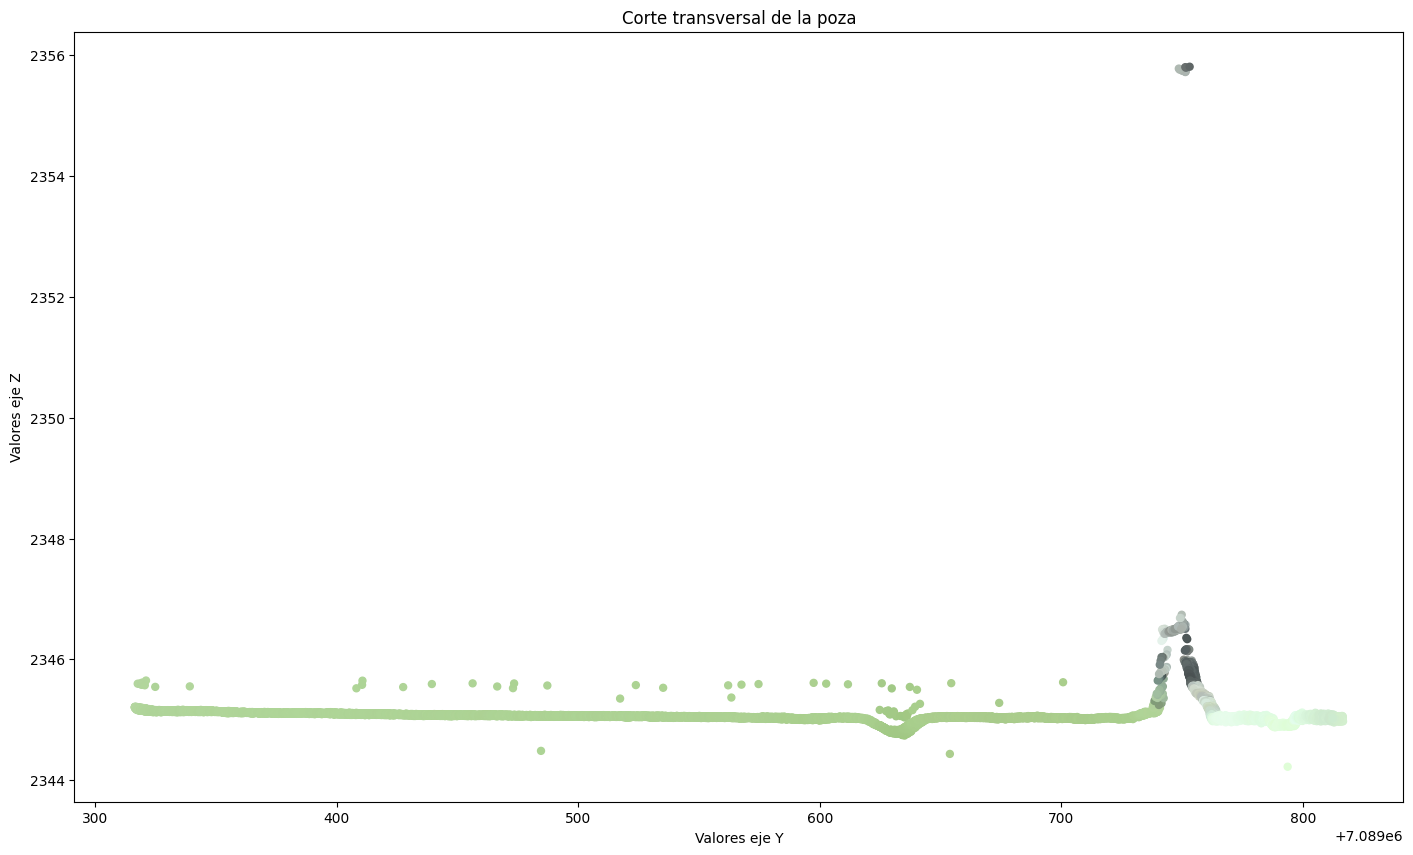

In [45]:
plt.figure(figsize=(20, 10))
selected_points = diagonal_points
selected_colors = rgba_colors[mask]
plt.scatter(selected_points[:, 1]*-1, selected_points[:, 2], c=selected_colors/255, s=25)
plt.xlabel('Valores eje Y')
plt.ylabel('Valores eje Z')
plt.title('Corte transversal de la poza')
# Adjust the aspect ratio of the plot to make sure both axes are proportional
plt.gca().set_aspect(25)
plt.show()

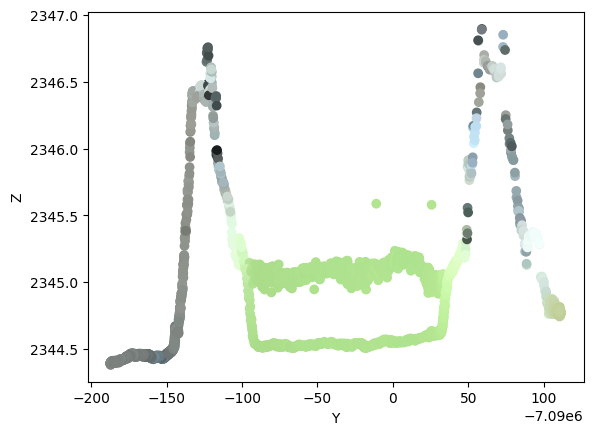

In [95]:
new_points = point_cloud.points
# extract all points with np.mean(x)
median_x = np.median(new_points[:, 0])
# select indexes by two conditions
selected_indexes = np.where((new_points[:, 0] > median_x - 0.5) & (new_points[:, 0] < median_x + 0.5))[0]
selected_points = new_points[selected_indexes]
selected_colors = rgba_colors[selected_indexes]
# plot selected points in scatter 2d plot in real axis values
plt.scatter(selected_points[:, 1], selected_points[:, 2], c=selected_colors/255)
plt.xlabel('Y')
plt.ylabel('Z')
plt.show()
#picked_points = []

In [188]:
import numpy as np
import pyvista as pv
from sklearn.decomposition import PCA


class PCARoutine:
    def __init__(self, points):
        self.original_points = points
        self.points = points  # Points to visualize
        self.output = pv.PolyData(points)
        self.kwargs = {
            'scale': 1.0,
            'rotate_x': 0.0,
            'rotate_y': 0.0,
            'rotate_z': 0.0,
        }
        self.update()

    def __call__(self, param, value):
        self.kwargs[param] = value
        self.update()

    def update(self):
        # Step 1: Translate the point cloud to align its centroid with the origin
        centroid = np.mean(self.original_points, axis=0)
        points_centered = self.original_points - centroid

        # Step 2: Apply scaling
        points_scaled = points_centered * self.kwargs['scale']

        # Step 3: Use PCA for alignment
        pca = PCA(n_components=3)
        pca.fit(points_scaled)
        rotation_matrix = pca.components_.T

        # Rotate points using updated angles
        angles = np.radians([
            self.kwargs['rotate_x'],
            self.kwargs['rotate_y'],
            self.kwargs['rotate_z'],
        ])
        rx = np.array([[1, 0, 0],
                       [0, np.cos(angles[0]), -np.sin(angles[0])],
                       [0, np.sin(angles[0]), np.cos(angles[0])]])
        ry = np.array([[np.cos(angles[1]), 0, np.sin(angles[1])],
                       [0, 1, 0],
                       [-np.sin(angles[1]), 0, np.cos(angles[1])]])
        rz = np.array([[np.cos(angles[2]), -np.sin(angles[2]), 0],
                       [np.sin(angles[2]), np.cos(angles[2]), 0],
                       [0, 0, 1]])

        rotation_matrix_combined = rz @ ry @ rx
        points_rotated = points_scaled @ rotation_matrix_combined

        # Update the PyVista mesh
        self.points = points_rotated
        self.output.points = points_rotated

# Create the PCA routine
engine = PCARoutine(local_maxima)

# Visualization
p = pv.Plotter()
engine.output["colors"]= rgba_colors
 # Add the point cloud with a clip box, using the colors
p.add_mesh_clip_box(engine.output, scalars="colors", rgb=True)
#p.add_mesh(engine.output, render_points_as_spheres=True, point_size=8, color='blue')

# Add sliders
# p.add_slider_widget(
#     callback=lambda value: engine('scale', value),
#     rng=[0.5, 2.0],
#     value=1.0,
#     title="Scale",
#     pointa=(0.025, 0.1),
#     pointb=(0.31, 0.1),
#     style='modern',
# )
p.add_slider_widget(
    callback=lambda value: engine('rotate_x', value),
    rng=[-180, 180],
    value=0,
    title="Rotate X",
    pointa=(0.025, 0.1),
     pointb=(0.31, 0.1),
    style='modern',
)
p.add_slider_widget(
    callback=lambda value: engine('rotate_y', value),
    rng=[-180, 180],
    value=0,
    title="Rotate Y",
    pointa=(0.35, 0.1),
    pointb=(0.64, 0.1),
    style='modern',
)
p.add_slider_widget(
    callback=lambda value: engine('rotate_z', value),
    rng=[-180, 180],
    value=0,
    title="Rotate Z",
    pointa=(0.67, 0.1),
    pointb=(0.96, 0.1),
    style='modern',
)

p.show()

Widget(value='<iframe src="http://localhost:35371/index.html?ui=P_0x7c8997fb80b0_7&reconnect=auto" class="pyvi…

In [112]:
# Create a new point cloud with the selected points
point_cloud["colors"] = rgba_colors
filtered_point_cloud = point_cloud.extract_points(p.box_clipped_meshes[0].cells)

In [113]:
np.where(classes==65)

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([   3405,   11906,   13546,   19205,   23339,   24429,   26051,
          27640,   35031,   36691,   41058,   45891,   48520,   51853,
          52484,   52499,   54141,   59123,   64157,   65848,   69898,
          71563,   74107,   75928,   87511,   99922,  110697,  112193,
         116467,  118003,  119877,  124739,  128781,  132090,  147873,
         152886,  166954,  170439,  172106,  183457,  193422,  206694,
         209153,  210838,  218322,  235745,  243255,  253940,  267293,
         270657,  271354,  278895,  292155,  298745,  299594,  304620,
         309483,  309536,  311267,  312031,  313723,  313766

In [114]:
point_cloud.points.shape

(1934796, 3)

In [115]:
# water points are classified as 65
water_points = point_cloud.points[np.where(classes == 65)]
#water_colors = rgba_colors[np.where(classes == 65)]
water_cloud = pv.PolyData(water_points)
#water_cloud['colors'] = water_colors
# underwater points are classified as 66
underwater_points = point_cloud.points[np.where(classes == 66)]
#underwater_colors = rgba_colors[np.where(classes == 66)]
underwater_cloud = pv.PolyData(underwater_points)
#underwater_cloud['colors'] = underwater_colors

IndexError: index 3405 is out of bounds for axis 1 with size 3

In [116]:
new_plotter = pv.Plotter()
new_plotter.add_mesh(filtered_point_cloud, show_edges=False, scalars="colors", rgb=True)
new_plotter.show()

Widget(value='<iframe src="http://localhost:35371/index.html?ui=P_0x7c8997f11a90_4&reconnect=auto" class="pyvi…

In [117]:
filtered_point_cloud

UnstructuredGrid (0x7c89a036ce20)
  N Cells:    702991
  N Points:   702991
  X Bounds:   -9.169e+06, -9.168e+06
  Y Bounds:   -7.090e+06, -7.089e+06
  Z Bounds:   2.344e+03, 2.347e+03
  N Arrays:   3

In [118]:
local_z_points = filtered_point_cloud.points[:,2]

In [119]:
import numpy as np
from sklearn.mixture import GaussianMixture

def find_gaussian_components(data, max_components=10, threshold=1e-3):
    """
    Quickly find the Gaussian distributions that compose a given distribution.
    
    Args:
        data (np.ndarray): Input data (1D or 2D array).
        max_components (int): Maximum number of components to test.
        threshold (float): Minimum weight threshold to filter out negligible components.
    
    Returns:
        dict: A dictionary containing the means, covariances, and weights of the Gaussian components.
    """
    # Fit Gaussian Mixture Model (GMM)
    gmm = GaussianMixture(n_components=max_components, random_state=42).fit(data.reshape(-1, 1))
    
    # Filter components with significant weights
    significant_indices = gmm.weights_ > threshold
    means = gmm.means_[significant_indices].flatten()
    covariances = gmm.covariances_[significant_indices].flatten()
    weights = gmm.weights_[significant_indices]

    # sort by means in ascending order
    sorted_indices = np.argsort(means)
    means = means[sorted_indices]
    covariances = covariances[sorted_indices]
    weights = weights[sorted_indices]
    
    # Return significant components
    return {
        "means": means,
        "covariances": covariances,
        "weights": weights
    }


In [120]:
data = local_z_points

In [121]:
components = find_gaussian_components(data, max_components=2, threshold=0.1)

In [122]:
components

{'means': array([2345.06584579]),
 'covariances': array([0.00146309]),
 'weights': array([0.97299392])}

In [123]:
def find_percentile_1_50_99(mean, covariance):
    """
    Find the 1st, 50th, and 99th percentiles of a Gaussian distribution.
    
    Args:
        mean (float): Mean of the Gaussian distribution.
        covariance (float): Covariance of the Gaussian distribution.
        weight (float): Weight of the Gaussian distribution.
    
    Returns:
        tuple: The 1st, 50th, and 99th percentiles.
    """
    # Calculate the standard deviation
    std = np.sqrt(covariance)
    
    # Calculate the percentiles
    p1 = mean - 2.33 * std
    p2 = mean
    p3 = mean + 2.33 * std
    
    return p1, p2, p3

In [124]:
upper_index = np.argmax(components['means'])
upper_point = components['means'][upper_index]
upper_covariance = components['covariances'][upper_index]
upper_percentiles = find_percentile_1_50_99(upper_point, upper_covariance)
lower_index = np.argmin(components['means'])
lower_point = components['means'][lower_index]
lower_covariance = components['covariances'][lower_index]
lower_percentiles = find_percentile_1_50_99(lower_point, lower_covariance)

In [125]:
upper_percentiles, lower_percentiles

((2344.9767224280467, 2345.0658457901823, 2345.154969152318),
 (2344.9767224280467, 2345.0658457901823, 2345.154969152318))

(array([7.9000e+01, 6.2320e+03, 6.0906e+05, 8.3633e+04, 3.3980e+03,
        5.8400e+02, 1.0000e+00, 1.0000e+00, 1.0000e+00, 2.0000e+00]),
 array([2344.367   , 2344.617125, 2344.86725 , 2345.117375, 2345.3675  ,
        2345.617625, 2345.86775 , 2346.117875, 2346.368   , 2346.618125,
        2346.86825 ]),
 <BarContainer object of 10 artists>)

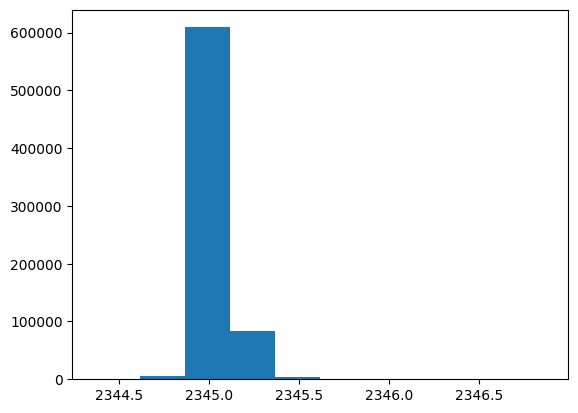

In [126]:
plt.hist(data)

2344.9767224280467 2345.0658457901823 2345.154969152318
2344.9767224280467 2345.0658457901823 2345.154969152318


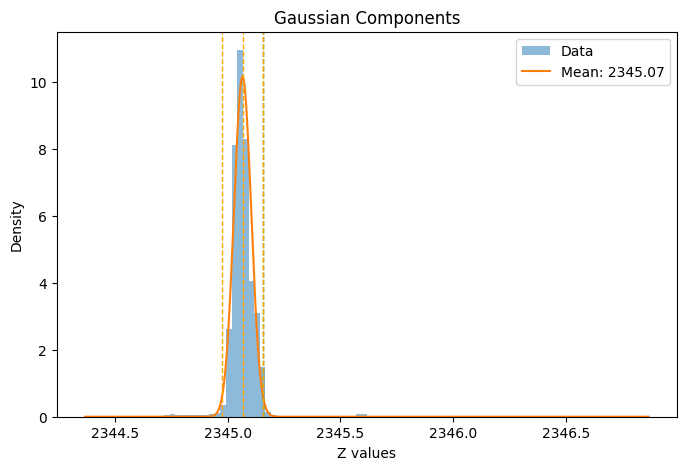

In [158]:
x = np.linspace(data.min(), data.max(), 1000).reshape(-1, 1)
plt.figure(figsize=(8, 5))
plt.hist(data, bins=100, density=True, alpha=0.5, label='Data')
for i, (mean, covariance, weight) in enumerate(zip(components['means'], components['covariances'], components['weights'])):
    gaussian = weight * (1 / np.sqrt(2 * np.pi * covariance)) * np.exp(-0.5 * ((x - mean) ** 2) / covariance)
    plt.plot(x, gaussian, label=f'Mean: {mean:.2f}')
# plot vlines in the 1st, 50th, and 99th percentiles of the upper and lower components
#plt.axvline(upper_percentiles[0], color='orange', linestyle='dashed', linewidth=1)
#plt.axvline(upper_percentiles[1], color='orange', linestyle='dashed', linewidth=1)
plt.axvline(upper_percentiles[2], color='g', linestyle='dashed', linewidth=1)
plt.axvline(lower_percentiles[0], color='orange', linestyle='dashed', linewidth=1)
plt.axvline(lower_percentiles[1], color='orange', linestyle='dashed', linewidth=1)
plt.axvline(lower_percentiles[2], color='orange', linestyle='dashed', linewidth=1)
print(upper_percentiles[0], upper_percentiles[1], upper_percentiles[2])
print(lower_percentiles[0], lower_percentiles[1], lower_percentiles[2])
plt.title("Gaussian Components")
plt.xlabel("Z values")
plt.ylabel("Density")
plt.legend()
plt.show()

In [27]:
# get the diff between the 99th percentile of the upper and 1st percentile of the lower
diff_1 = upper_percentiles[2] - lower_percentiles[0]
print("Difference between the 99th percentile of the upper and 1st percentile of the lower: ", np.round(diff_1*100, 2), "cm")
# get the diff between the 99th percentile of the upper and 50th percentile of the lower
diff_2 = upper_percentiles[2] - lower_percentiles[1]
print("Difference between the 99th percentile of the upper and 50th percentile of the lower: ", np.round(diff_2*100, 2), "cm")
# get the diff between the 99th percentile of the upper and 99th percentile of the lower
diff_3 = upper_percentiles[2] - lower_percentiles[2]
print("Difference between the 99th percentile of the upper and 99th percentile of the lower: ", np.round(diff_3*100, 2), "cm")
mean = (diff_2 + diff_3) / 2
print("Mean: ", np.round(mean*100, 2), "cm")

Difference between the 99th percentile of the upper and 1st percentile of the lower:  166.32 cm
Difference between the 99th percentile of the upper and 50th percentile of the lower:  94.47 cm
Difference between the 99th percentile of the upper and 99th percentile of the lower:  22.62 cm
Mean:  58.55 cm


In [111]:
(upper_percentiles[2]-lower_percentiles[2])*100

0.0